In [1]:
from userModel import User
import pandas as pd
import numpy as np
from tqdm import tqdm
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

from agentDev import markovianAgent,lastAgent,get_report,shortcut_track,randomAgent

In [2]:
def generate(agent) :
    Shortcuts = []
    Actions = []
    commands = []
    finish = False 
    i = 0
    command,shortcut = 0,True
    adversity = np.random.uniform(0,1)
    log = np.random.uniform(-5,-1)
    init_forget = 10**(log)
    cumul_forget = np.random.uniform(0.2,0.7)
    interrupt = np.random.uniform(0,1)
    adam =  User(adversity,init_forget,cumul_forget,interrupt,"z")
    while (i<100) : 
            action = agent.get_action(command,shortcut)
            reward, next_command,shortcut ,done = adam.interact(action)
            Actions.append(action)
            commands.append(next_command)
            Shortcuts.append(shortcut*1)
            i +=1
    data = np.array([Shortcuts,Actions,commands]).astype(np.float64)/20
    return data,adam.adversity,interrupt,cumul_forget,log

In [3]:
adam = User(0.6,0.01,0.5,0.3,"z")

In [4]:
agent = randomAgent(2)

In [6]:
# data , adv = generate(agent)

In [8]:
X = []
adv = []
inter = []
cumu = []
log = []
from tqdm import tqdm
for i in tqdm(range(10000)) :
    data,adve,intere,cumue,loge = generate(agent)
    X.append(data)
    adv.append(adve)
    inter.append(intere)
    cumu.append(cumue)
    log.append(loge)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [07:35<00:00, 21.97it/s]


In [9]:
for i in range(len(X)) : 
    X[i] = X[i].T.reshape(1,100,3)

In [10]:
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset

In [11]:
class CNN(nn.Module) : 
    def __init__(self, in_channels =1):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=25,kernel_size = (50,3),stride=(1,1),padding=(1,1))
        self.conv15 = nn.Conv2d(in_channels=25, out_channels=8,kernel_size = (3,3),stride=(1,1),padding=(1,1))
        self.pool = nn.MaxPool2d(kernel_size = (2,2),stride=(1,1))
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16,kernel_size = (3,3),stride=(1,1),padding=(1,1))
        self.fc1 = nn.Linear(816,20)
        self.fc2 = nn.Linear(20,1)
    def forward(self,x) : 
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv15(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0],-1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [12]:
model = CNN()
model(torch.tensor([X[0]],dtype=torch.float32))

tensor([[0.1780]], grad_fn=<AddmmBackward0>)

In [13]:
class UserDataset(Dataset) :
    def __init__(self,X,y) : 
        self.data = X
        self.label = y
    
    def __len__(self) : 
        return len(self.data)
    
    def __getitem__(self , index) : 
        return (torch.tensor(self.data[index],dtype=torch.float32) ,
                torch.tensor(self.label[index],dtype=torch.float32))

In [73]:
y = cumu

In [74]:
train_dataset = UserDataset(X[:7000],y[:7000])
test_dataset = UserDataset(X[7000:],y[7000:])
train_loader = DataLoader(dataset = train_dataset,
                          batch_size= 512)
test_loader = DataLoader(dataset = test_dataset,
                          batch_size= 512)

In [75]:
def checkit(loader,model) :
    mse = 0
    samples = 0
    with torch.no_grad() :
        for x,y in loader :
            scores = model(x)
            mse += criterion(scores,y)*scores.size(0)
            samples += scores.size(0)
        mss = mse/samples
        print(mss)

In [76]:
model = CNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.0005)

for epoch in range(21) :
    for idx, (data,targets) in enumerate(train_loader) :
        scores = model(data)
        loss = criterion(scores,targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0 :
        print(f"train")
        checkit(train_loader,model)
        print(f"test")
        checkit(test_loader,model)
        print('###############')

train
tensor(0.0471)
test
tensor(0.0468)
###############
train
tensor(0.0206)
test
tensor(0.0209)
###############
train
tensor(0.0207)
test
tensor(0.0210)
###############


0.2832723979702237


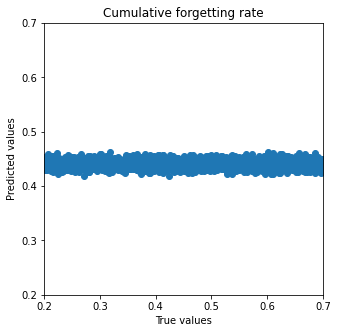

In [77]:
pred = []
true = []
for i in range(3000) :
    pred.append(model(torch.tensor([X[i + 7000]],dtype=torch.float32)).detach().numpy().flatten())
    true.append(y[i + 7000])
    
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
print(mean_absolute_percentage_error(pred,true))
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.scatter(true,pred)
plt.xlabel("True values")
plt.xlim(0.2,0.7)
plt.ylim(0.2,0.7)
plt.ylabel("Predicted values")
plt.title("Cumulative forgetting rate")
plt.savefig("cumuPred.jpg")

In [72]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XX, y, test_size=0.33, random_state=42)

NameError: name 'XX' is not defined

In [ ]:
from catboost import CatBoostRegressor
cb_reg_1 = CatBoostRegressor(random_seed=13, verbose=100)
cb_reg_1.fit(X_train, y_train, eval_set=(X_test,y_test) ,plot=True)

0.09796420542814863


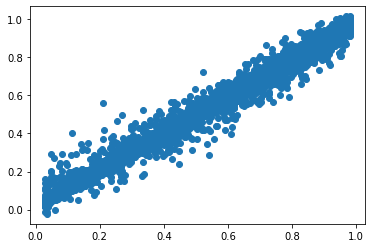

In [23]:
pred = []
true = []
for i in range(3000) :
    pred.append(cb_reg_1.predict(XX[i+7000]))
    true.append(y[i + 7000])
    
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
print(mean_absolute_percentage_error(pred,true))
import matplotlib.pyplot as plt
plt.scatter(true,pred)

In [26]:
i = 0
true[2], pred[2]

(0.9738902956590609, 0.9864205062363884)